# Comparison of the Train time and Inference Time of MNIST MLP and 
# CNN on CPUs and GPUs with `keras`

### Jack Dinsmore
The purpose of this notebook is to determine the relative speeds of training MNIST on CPUs and GPUs, as well as the relative speeds of inference. We will do this both for CNN and for MLP implementations of MNIST. It is a mimicry of one of the experiments described in [this paper](https://arxiv.org/pdf/1904.08986.pdf) (arXiv:1904.08986v1 \[physics.data-an\]). Next, we will transform the code in this notebook into bare `tensorflow` code and compare runtime, set the GPU implementation up as a service, then transform the code again into a form that can be run on TPUs and perform a similar analysis.

The code for the implementations of mnist using MLP with `keras` were pulled from [this github](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py), and the code for the CNN impementation was pulled from [this file](https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py) on the same github. I significantly changed both so that they would be more comparable.

## Imports
We import all the necessary classes and set some of the globals for the program. `INFERENCE_NUM` is the number of trials we will make when computing the time per inference of the model for each batch size for each machine; we average all the trial times together at the end. `NUM_CLASSES` is the number of categories to train mnist on. `NUM_EPOCHS` describes the number of epochs to run training over. `IMG_ROWS` and `IMG_COLS` will be the height and width respectively of the images. `BATCH_SIZES` is a list of sizes to over which compute runtimes, and it must be sorted from low to high in order for the graph to be made in the last step.

In [2]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import RMSprop, Adadelta
from keras.utils import to_categorical
from keras import backend as K
import tensorflow as tf
from time import time
import random
import numpy as np

NUM_CLASSES=10
NUM_EPOCHS=5
IMG_ROWS=28
IMG_COLS=28

start_power = 0
end_power = 4
BATCH_SIZES = []
for i in range(start_power, end_power):
    BATCH_SIZES += list(range(10**i, 10**(i+1), 10**i))
BATCH_SIZES += [10**end_power]
BATCH_SIZES = [128]

## Creating MNIST

Having imported all the necessary modules and defined the constants, we need to implement MNIST in `keras`. Since we plan to implement MNIST with MLP and with CNN, we will first create a parent class holding the common functions of both. Later, we will define two subclasses, one for MLP and once for CNN. The parent class has several functions:
- `_load` and `_finish_load` load the default `keras` MNIST dataset in whatever form MLP or CNN wants the data to be in.
- `_create` creates the MNIST model with a specific batch size.
- `_load_inferences` loads several randomly generated images to be inferred on.
- `_train` trains the MNIST model, keeping track of the time it takes to do so, and returns that time. The time it returns is actually the time to train _per iteration_, where one iteration is the number of epochs times the number of data points divided by the batch size.
- `_predict` runs a number of inferences equal to the batch size the model was trained on and returns the time per inference. It does this multiple times to reduce uncertainty.
- `get_data` runs all of the above functions in order to get the train times and inference times for the given machine type and implementation (MLP or CNN) for all the batch sizes in `BATCH_SIZE`.

In [ ]:
class MNIST:
    def __init__(self, machine):
        self.machine = machine
        self.model = None
        (self.x_train, self.y_train), (self.x_test, self.y_test) = mnist.load_data()
        
    def _load(self):
        # To be overrided
        pass
    
    def _load_inferences(self, batch_size):
        # To be overrided
        pass
    
    def _finish_load(self):
        self.x_train = self.x_train.astype('float32')
        self.x_test = self.x_test.astype('float32')
        self.x_train /= 255
        self.x_test /= 255
        print(self.x_train.shape[0], 'train samples')
        print(self.x_test.shape[0], 'test samples')

        # convert class vectors to binary class matrices
        self.y_train = to_categorical(self.y_train, NUM_CLASSES)
        self.y_test = to_categorical(self.y_test, NUM_CLASSES)
    
    def _create(self):
        # To be overrided
        pass
    
    def _train(self, batch_size):
        start_time = time()
        history = self.model.fit(self.x_train, self.y_train, batch_size=batch_size, epochs=NUM_EPOCHS, verbose=1,
                            validation_data=(self.x_test, self.y_test))
        end_time = time()
        iterations = NUM_EPOCHS * (self.x_train.shape[0] / batch_size)
        train_time = (end_time - start_time) / iterations

        #loss, accuracy = self.model.evaluate(self.x_test, self.y_test, verbose=0)
        return train_time
    
    def _predict(self, batch_size):
        inference_time = 0
        start_inference = time()
        inference_num = 0
        while True: # Do multiple trials
            inputs = self._load_inferences(batch_size)

            start_time = time()
            self.model.predict(inputs)
            end_time = time()
            inference_time += end_time - start_time
            inference_num += 1
            if end_time - start_inference > 5: # Break when we have 5 seconds worth of inferences.
                break
        inference_time /= inference_num

        return inference_time / batch_size, inference_num
    
    def get_data(self):
        self.train_times = []
        self.inference_times = []
        self.max_train = 0
        self.max_inference = 0
        
        self._load()
        self._create()
        for batch_size in BATCH_SIZES:
            train_time = self._train(batch_size)
            inference_time, inference_num = self._predict(batch_size)
            print('\n','Batch size:', batch_size, '\tTrain time:', train_time, '\tInference time', inference_time, '(%s)'%inference_num
            print('+'*100)
            self.train_times.append(train_time)
            self.inference_times.append(inference_time)

Now that we have created our superclass, we may create two subclasses, one for MLP and one for CNN. They each handle the data and create the model differently, but in all other respects, `keras` allows us to treat them similarly, hence the superclass functions.

In [4]:
class MNIST_MLP(MNIST):
    def _load(self):
        self.x_train = self.x_train.reshape(60000, IMG_ROWS*IMG_COLS)
        self.x_test = self.x_test.reshape(10000, IMG_ROWS*IMG_COLS)
        
        self._finish_load()
        
    def _load_inferences(self, batch_size):
        return np.random.rand(batch_size, IMG_ROWS*IMG_COLS)
    
    def _create(self):
        with tf.device(self.machine):
            self.model = Sequential()
            self.model.add(Dense(512, activation='relu', input_shape=(784,)))
            self.model.add(Dropout(0.2))
            self.model.add(Dense(512, activation='relu'))
            self.model.add(Dropout(0.2))
            self.model.add(Dense(NUM_CLASSES, activation='softmax'))

            self.model.compile(loss='categorical_crossentropy',
                          optimizer=RMSprop(),
                          metrics=['accuracy'])

In [5]:
class MNIST_CNN(MNIST):
    def _load(self):
        if K.image_data_format() == 'channels_first':
            self.x_train = self.x_train.reshape(self.x_train.shape[0], 1, IMG_ROWS, IMG_COLS)
            self.x_test = self.x_test.reshape(self.x_test.shape[0], 1, IMG_ROWS, IMG_COLS)
            self.input_shape = (1, IMG_ROWS, IMG_COLS)
        else:
            self.x_train = self.x_train.reshape(self.x_train.shape[0], IMG_ROWS, IMG_COLS, 1)
            self.x_test = self.x_test.reshape(self.x_test.shape[0], IMG_ROWS, IMG_COLS, 1)
            self.input_shape = (IMG_ROWS, IMG_COLS, 1)
        
        self._finish_load()
        
    def _load_inferences(self, batch_size):
        return np.random.rand(batch_size, IMG_ROWS, IMG_COLS, 1)
    
    def _create(self):
        with tf.device(self.machine):
            self.model = Sequential()
            self.model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=self.input_shape))
            self.model.add(Conv2D(64, (3, 3), activation='relu'))
            self.model.add(MaxPooling2D(pool_size=(2, 2)))
            self.model.add(Dropout(0.25))
            self.model.add(Flatten())
            self.model.add(Dense(128, activation='relu'))
            self.model.add(Dropout(0.5))
            self.model.add(Dense(NUM_CLASSES, activation='softmax'))

            self.model.compile(loss='categorical_crossentropy',
                          optimizer=Adadelta(),
                          metrics=['accuracy'])

## Gathering Data
Now that we have defined all the methods we need to gather data on the train time and inference time of MNIST on different machines with different implementations, all we need to do is call the functions. `get_data` will generate our lists of train times and inference times for every batch size. This will take several hours.

In [6]:
print("MNIST MLP")
print()
mlp_cpu = MNIST_MLP('/cpu:0')
mlp_gpu = MNIST_MLP('/gpu:0')

print()
print("TRAIN ON CPUS")
print()
print('+'*100)
mlp_cpu.get_data()

print()
print("TRAIN ON GPUS")
print()
print('+'*100)
mlp_gpu.get_data()

print()
print('+'*47, "DONE", '+'*47)

MNIST MLP


TRAIN ON CPUS

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
60000 train samples
10000 test samples
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 26s 439us/step - loss: 0.2441 - acc: 0.9239 - val_loss: 0.1019 - val_acc: 0.9688
Epoch 2/5
60000/60000 [==============================] - 9s 158us/step - loss: 0.1047 - acc: 0.9685 - val_loss: 0.0822 - val_acc: 0.9754
Epoch 3/5
60000/60000 [==============================] - 9s 154us/step - loss: 0.0744 - acc: 0.9772 - val_loss: 0.0707 - val_acc: 0.9806
Epoch 4/5
60000/60000 [==============================] - 9s 153us/step - loss: 0.0592 - acc: 0.9820 - val_loss: 0.0781 - val_acc: 0.9796

Now we may do the same for the CNN implementations of MNIST.

In [11]:
print("MNIST_CNN")
cnn_cpu = MNIST_CNN('/cpu:0')
cnn_gpu = MNIST_CNN('/gpu:0')

print()
print("TRAIN ON CPUS")
print()
print('+'*100)
cnn_cpu.get_data()

print()
print("TRAIN ON GPUS")
print()
print('+'*100)
cnn_gpu.get_data()

print()
print('+'*47, "DONE", '+'*47)

MNIST_CNN

TRAIN ON CPUS

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

TRAIN ON GPUS

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 6s 107us/step - loss: 0.2639 - acc: 0.9191 - val_loss: 0.0742 - val_acc: 0.9759
Epoch 2/5
60000/60000 [==============================] - 3s 52us/step - loss: 0.0895 - acc: 0.9741 - val_loss: 0.0475 - val_acc: 0.9829
Epoch 3/5
60000/60000 [==============================] - 3s 52us/step - loss: 0.0660 - acc: 0.9805 - val_loss: 0.0343 - val_acc: 0.9882
Epoch 4/5
60000/60000 [==============================] - 3s 52us/step - loss: 0.0545 - acc: 0.9840 - val_loss: 0.0345 - val_acc: 0.9882
Epoch 5/5
60000/60000 [==============================] - 3s 51us/step - loss: 0.0468 - acc: 0.9859 - val_loss: 0.0317 - va

## Plotting the Data
Now we wish to compare train time and inference time between CPUs and GPUs. We will make two plots, one for train time and one for inference time. First, we import the required modules. Each plot will have both MLP and CNN on it, and they can be compared or viewed as separate. First we import the required modules.

In general, MLP is plotted with cool colors and CNN is plotted with warm colors.

In [7]:
import numpy as np
import matplotlib.pyplot as plt

x = np.array(BATCH_SIZES)

Then we plot the data we have gathered and obtain a graph of train times

NameError: name 'cnn_cpu' is not defined

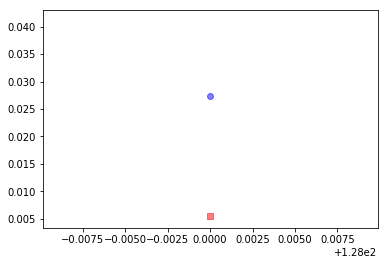

In [8]:
plt.scatter(x, mlp_cpu.train_times, c='b', alpha = 0.5)
plt.scatter(x, mlp_gpu.train_times, c='r', alpha = 0.5, marker='s')
plt.scatter(x, cnn_cpu.train_times, c='y', alpha = 0.5, marker='^')
plt.scatter(x, cnn_gpu.train_times, c='m', alpha = 0.5, marker='v')
plt.xlabel('Batch size')
plt.ylabel('Train time (s)')
plt.xscale('log')
plt.yscale('log')
plt.legend(['MLP CPU', 'MLP GPU', 'CNN CPU', 'CNN GPU'])
plt.show()

and a graph of inference times.

In [ ]:
plt.scatter(x, mlp_cpu.inference_times, c='b', alpha = 0.5)
plt.scatter(x, mlp_gpu.inference_times, c='r', alpha = 0.5, marker='s')
plt.scatter(x, cnn_cpu.inference_times, c='y', alpha = 0.5, marker='^')
plt.scatter(x, cnn_gpu.inference_times, c='m', alpha = 0.5, marker='v')
plt.xlabel('Batch size')
plt.ylabel('Train time (s)')
plt.xscale('log')
plt.yscale('log')
plt.legend(['MLP CPU', 'MLP GPU', 'CNN CPU', 'CNN GPU'])
plt.show()

We can also make a couple other plots, such as the performance gain in train time and inference time in using GPUs over CPUs. This is train time

In [ ]:
def get_improvement(cpu_times, gpu_times):
    gain = []
    for i in range(cpu_times.shape[0]):
        gain.append(cpu_times[i] / gpu_times[i] * 100)
    return np.array(gain)

gain_train_mlp = get_improvement(mlp_cpu.train_times, mlp_gpu.train_times)
gain_train_cnn = get_improvement(cnn_cpu.train_times, cnn_gpu.train_times)

plt.scatter(x, gain_train_mlp, c='k', alpha = 0.5, marker = 'd')
plt.scatter(x, gain_train_cnn, c='c', alpha = 0.5, marker = '>')
plt.xlabel('Batch size')
plt.ylabel('Train speed gain by using GPUs (%)')
plt.xscale('log')
plt.yscale('linear')
plt.legend(['MLP', 'CNN'])
plt.show()

and this is inference time.

In [ ]:
gain_inference_mlp = get_improvement(mlp_cpu.inference_times, mlp_gpu.inference_times)
gain_inference_cnn = get_improvement(cnn_cpu.inference_times, cnn_gpu.inference_times)

plt.scatter(x, gain_inference_mlp, c='k', alpha = 0.5, marker='d')
plt.scatter(x, gain_inference_cnn, c='c', alpha = 0.5, marker='>')
plt.xlabel('Batch size')
plt.ylabel('Inference speed gain by using GPUs (%)')
plt.xscale('log')
plt.yscale('linear')
plt.legend(['MLP', 'CNN'])
plt.show()

The collection of the above data concludes this experiment.